**Weekly petrol and diesel data in the UK**

- Please view this in a nbviewer, an circle icon on the top right of the notebook will direct you towards a more interactive notebook.


**Forecasting Section**

- For this section, I looked took the petrol pump price data over time and used bi-directional LSTM model to fit and predict future values of weekly petrol data in the UK.


- In this section, I did not implement de-trending to view how the results would fair compared to de-treding the data.


- A univariate approach was used for this, as when additional features such as petrol_duty_rate, petrol_vat_percent_rate, and Year were added, it did not improve the model. However, this model, can be adapted to a multivariate time series, by feeding it x columns data and changing the num_x to numbers of features.


- Furthermore, 90% (841 values) of the data was used for training and 5% (37 values) was used for testing.


- Also at the end, I triend to predict 7 weeks of data into the future with the model.

**References:**

- **Predicting unknown future:** https://www.kaggle.com/fatmakursun/time-series-forecasting-unknown-future


- **LSTM inspiration:** https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('seaborn-whitegrid')
sns.set(color_codes=True)

from statsmodels.graphics.tsaplots import quarter_plot


import plotly.graph_objects as go

from pylab import rcParams
rcParams['figure.figsize'] = 16, 10


In [41]:
data = pd.read_csv('CSV_180520.csv', sep=',', encoding='unicode_escape', header=2)
data.head()

,Date,ULSP,ULSD,ULSP.1,ULSD.1,ULSP.2,ULSD.2,Unnamed: 7,ULSD = Ultra low sulphur diesel,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,09/06/2003,74.59,76.77,45.82,45.82,17.5,17.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16/06/2003,74.47,76.69,45.82,45.82,17.5,17.5,NaN,ULSP and ULSD,NaN,NaN,NaN,NaN,NaN
2,23/06/2003,74.42,76.62,45.82,45.82,17.5,17.5,NaN,Duty rate per litre (£) from 7 March 2001,NaN,NaN,NaN,NaN,0.4582
3,30/06/2003,74.35,76.51,45.82,45.82,17.5,17.5,NaN,Duty rate per litre (£) from 1 October 2003,NaN,NaN,NaN,NaN,0.4710
4,07/07/2003,74.28,76.46,45.82,45.82,17.5,17.5,NaN,Duty rate per litre (£) from 7 December 2006,NaN,NaN,NaN,NaN,0.4835


In [42]:
# Cleaning some data

data = data.rename(columns={'ULSP':'petrol_pump_price', 'ULSD':'diesel_pump_price',
                     'ULSP.1':'petrol_duty_rate', 'ULSD.1':'diesel_duty_rate',
                    'ULSP.2':'petrol_vat_percent_rate', 'ULSD.2':'diesel_vat_percent_rate'})

data = data.iloc[:,0:7]

data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['dayofweek'] = data['Date'].dt.dayofweek
data['quarter'] = data['Date'].dt.quarter

data.set_index('Date', inplace=True)

In [43]:
data.head()

,petrol_pump_price,diesel_pump_price,petrol_duty_rate,diesel_duty_rate,petrol_vat_percent_rate,diesel_vat_percent_rate,Year,Month,dayofweek,quarter
Date,,,,,,,,,,
2003-06-09,74.59,76.77,45.82,45.82,17.5,17.5,2003,6,0,2
2003-06-16,74.47,76.69,45.82,45.82,17.5,17.5,2003,6,0,2
2003-06-23,74.42,76.62,45.82,45.82,17.5,17.5,2003,6,0,2
2003-06-30,74.35,76.51,45.82,45.82,17.5,17.5,2003,6,0,2
2003-07-07,74.28,76.46,45.82,45.82,17.5,17.5,2003,7,0,3


In [44]:
data.index

DatetimeIndex(['2003-06-09', '2003-06-16', '2003-06-23', '2003-06-30',
               '2003-07-07', '2003-07-14', '2003-07-21', '2003-07-28',
               '2003-08-04', '2003-08-11',
               ...
               '2020-03-16', '2020-03-23', '2020-03-30', '2020-04-06',
               '2020-04-13', '2020-04-20', '2020-04-27', '2020-05-04',
               '2020-05-11', '2020-05-18'],
              dtype='datetime64[ns]', name='Date', length=885, freq=None)

### Plotting of Petrol and Diseal pump price over time

In [45]:
def interactive_scatter_2(actual_df, actual_name, predicted_df, predicted_name,
                         title="", yaxis_title="",xaxis_title=""):
    '''
    actual_df: dataframe of actual values
    actual_name: Name to be given for actual legend
    
    predicted_df: dataframe of predicted values
    predicted_name: Name to be fiven for predicted legend
    
    title: Title for the graph
    '''
    
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=actual_df.index,y=actual_df, name=actual_name))
    
    fig.add_trace(go.Scatter(x=predicted_df.index, y=predicted_df, name=predicted_name))
    fig.update_layout(title=title,yaxis_title=yaxis_title, xaxis_title=xaxis_title)
    fig.show(render="png")

In [46]:
interactive_scatter_2(data['diesel_pump_price'],"Diesel",
                     data['petrol_pump_price'], "Petrol",
                     title='Petrol and Diesel pump price in pence/litre over time',
                     yaxis_title='Pence per litre',xaxis_title='Date')

# Forecasting

In [47]:
petrol_data = data[['petrol_pump_price']]

In [48]:
diesel_data = data[['diesel_pump_price','diesel_duty_rate', 'diesel_vat_percent_rate', 'Year']]

In [49]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing, metrics
from keras.regularizers import l2

from keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow import keras

In [50]:
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [51]:
data_pet = petrol_data.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
sc = scaler.fit_transform(data_pet)

In [83]:
print(sc.shape)

(885, 1)


### Time windowed data set

In [53]:
def windowed_data_LSTM(timestep, sc):
    
    
    '''
    timestep: Number of timestep values, 7 days value
    sc: The scaled features
    num_x: number of features
    
    '''

    X= []
    Y= []

    # Make a list with time window 30 values(index 0 to 29) as X and Y as the 31st value (index 30)
    for i in range(len(sc)- (timestep)):
        X.append(sc[i:i+timestep])

        Y.append(sc[:,0][i+timestep])

    # Change the list of arrays to n dimensions array (training samples, window-size,1)
    X=np.asanyarray(X)
    print(X.shape)
    Y=np.asanyarray(Y)
    # Seperate the training and development(validation) set
    k = round(len(sc)*0.95) # 90%
    m = round(len(sc)*0.05) # 0.05%
    #l = round(len(sc)*0.10) # 
    print(k)
    print(m)
    #print(l)

    # Training data set for prediction
    Xtrain = X[:k,:,:]

    # Test data set for prediction
    Xtest = X[k:k+m,:,:] 

    # Set of labels to all the data in x_train (Actual values)
    Ytrain = Y[:k]

    # Set of labels to all the data in x_test (Actual values)
    Ytest= Y[k:k+m]  

    # The last 10% to check future predictions
    Ytest_future=Y[k+m:]
        
    return Xtrain, Xtest, Ytrain, Ytest, Ytest_future


In [54]:
timestep = 7 # Num of time steps
num_x = 1 # Num of variables/features

In [55]:
Xtrain, Xtest, Ytrain, Ytest, Ytest_future = windowed_data_LSTM(timestep, sc)

(878, 7, 1)
841
44


In [56]:
print(f'Shape for Xtrain: {Xtrain.shape}')
print(f'Shape for Xtest: {Xtest.shape}')
print('\n')
print(f'Shape for Ytrain: {Ytrain.shape}')
print(f'Shape for Ytest: {Ytest.shape}')
print('\n')
print(f'Shape for Ytest_future: {Ytest_future.shape}')

Shape for Xtrain: (841, 7, 1)
Shape for Xtest: (37, 7, 1)


Shape for Ytrain: (841,)
Shape for Ytest: (37,)


Shape for Ytest_future: (0,)


### Setting up the model

In [57]:
# Bidirectional LSTM
model = keras.Sequential()
model = keras.Sequential()
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128, 
                                                       activation = "relu",
                                                       kernel_regularizer=l2(0.001)),
                                     input_shape=(Xtrain.shape[1], Xtrain.shape[2])))

model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(units=1))
model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.0001)
)

In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 256)               133120    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 133,377
Trainable params: 133,377
Non-trainable params: 0
_________________________________________________________________


In [59]:
history = model.fit(
    Xtrain, Ytrain,
    epochs=100,
    batch_size=40,
    validation_data =(Xtest,Ytest),
    verbose=1,
    shuffle=False
)

Train on 841 samples, validate on 37 samples
Epoch 1/100
841/841 [==============================] - 2s 2ms/sample - loss: 0.3076 - val_loss: 0.3835
Epoch 2/100
841/841 [==============================] - 0s 261us/sample - loss: 0.2617 - val_loss: 0.3234
Epoch 3/100
841/841 [==============================] - 0s 239us/sample - loss: 0.2196 - val_loss: 0.2660
Epoch 4/100
841/841 [==============================] - 0s 243us/sample - loss: 0.1792 - val_loss: 0.2080
Epoch 5/100
841/841 [==============================] - 0s 242us/sample - loss: 0.1372 - val_loss: 0.1479
Epoch 6/100
841/841 [==============================] - 0s 241us/sample - loss: 0.0921 - val_loss: 0.0910
Epoch 7/100
841/841 [==============================] - 0s 263us/sample - loss: 0.0558 - val_loss: 0.0458
Epoch 8/100
841/841 [==============================] - 0s 241us/sample - loss: 0.0288 - val_loss: 0.0179
Epoch 9/100
841/841 [==============================] - 0s 316us/sample - loss: 0.0163 - val_loss: 0.0076
Epoch 10/100

Epoch 78/100
841/841 [==============================] - 0s 263us/sample - loss: 0.0054 - val_loss: 0.0036
Epoch 79/100
841/841 [==============================] - 0s 277us/sample - loss: 0.0056 - val_loss: 0.0039
Epoch 80/100
841/841 [==============================] - 0s 283us/sample - loss: 0.0054 - val_loss: 0.0032
Epoch 81/100
841/841 [==============================] - 0s 253us/sample - loss: 0.0054 - val_loss: 0.0034
Epoch 82/100
841/841 [==============================] - 0s 298us/sample - loss: 0.0053 - val_loss: 0.0035
Epoch 83/100
841/841 [==============================] - 0s 325us/sample - loss: 0.0046 - val_loss: 0.0035
Epoch 84/100
841/841 [==============================] - 0s 296us/sample - loss: 0.0047 - val_loss: 0.0036
Epoch 85/100
841/841 [==============================] - 0s 249us/sample - loss: 0.0052 - val_loss: 0.0034
Epoch 86/100
841/841 [==============================] - 0s 272us/sample - loss: 0.0049 - val_loss: 0.0036
Epoch 87/100
841/841 [========================

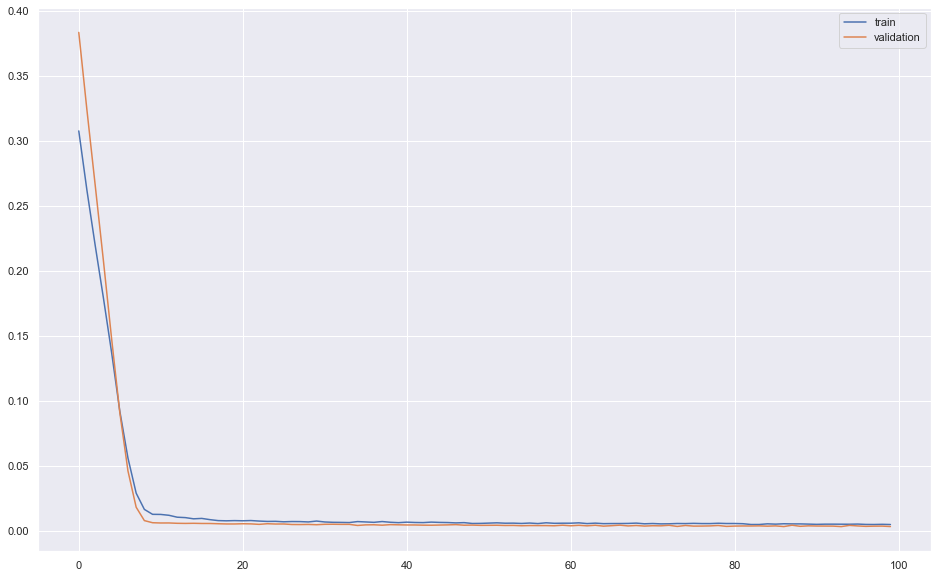

In [60]:

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

In [61]:
## 
train_predict = model.predict(Xtrain)
devPredict = model.predict(Xtest)

print(f'shape of train_predict: {train_predict.shape}')
print(f'shape of devPredict: {devPredict.shape}')

##

# reshape to sampes (number of variables which have time lagged values (timestep * features))
test_X = Xtrain.reshape((Xtrain.shape[0], timestep*Xtrain.shape[2]))
test_Y = Xtest.reshape((Xtest.shape[0], timestep*Xtest.shape[2]))
print('\n')
print(f'shape of test_X: {test_X.shape}')
print(f'shape of test_Y: {test_Y.shape}')


## we need to take the last values which are not the lagged values

# The gist of the change is that we concatenate the y or yhat column
# with the last x-1 features of the test dataset in order to inverse the scaling
inv_yhat = np.concatenate((train_predict, test_X[:, -(num_x-1):]), axis=1)
print(f'shape of inv_yhat concat: {inv_yhat.shape}')
inv_yhat2 = np.concatenate((devPredict, test_Y[:, -(num_x-1):]), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat2 = scaler.inverse_transform(inv_yhat2)

inv_yhat = inv_yhat[:,0]
inv_yhat2 = inv_yhat2[:,0]
print('\n')
print(f'shape of inv_yhat: {inv_yhat.shape}')
print(f'shape of inv_yhat2: {inv_yhat2.shape}')

# Inversing actual values

test_y = Ytrain.reshape((len(Ytrain), 1))
test_y2 = Ytest.reshape((len(Ytest), 1))

inv_y = np.concatenate((test_y, test_X[:, -(num_x-1):]), axis=1)
inv_y2 = np.concatenate((test_y2, test_Y[:, -(num_x-1):]), axis=1)

inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
inv_y2 = scaler.inverse_transform(inv_y2)
inv_y2 = inv_y2[:,0]

shape of train_predict: (841, 1)
shape of devPredict: (37, 1)


shape of test_X: (841, 7)
shape of test_Y: (37, 7)
shape of inv_yhat concat: (841, 4)


shape of inv_yhat: (841,)
shape of inv_yhat2: (37,)


In [62]:
def compute_RMSE(actual, predicted):
    np.sqrt(mean_squared_error(actual, predicted))

In [63]:
mse = mean_squared_error(inv_y, inv_yhat)
mse2 = mean_squared_error(inv_y2, inv_yhat2)
print('Train MSE: %.3f' % mse)
print('Test MSE: %.3f' % mse2)

Train MSE: 5.102
Test MSE: 10.504


In [64]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=inv_y, name="Actual_Train"))
fig.add_trace(go.Scatter(y=inv_yhat, name="Predicted_Train"))
fig.update_layout(title='Training data set result')
fig.show()

In [65]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=inv_y2, name="Actual_Test"))
fig.add_trace(go.Scatter(y=inv_yhat2, name="Predicted_Test"))
fig.update_layout(title='Training data set result')
fig.show()

### Testing with future predictions

In [66]:
import copy

In [67]:
Xtest.shape

(37, 7, 1)

In [68]:
# Yfut=np.asanyarray(Ytest_future)
# Yfut=Yfut.reshape(-1,1) 
# Ytest_future = scaler.inverse_transform(Yfut)

In [69]:
# Make a deep copy of Xtest so the matrix doesn't change
store_test =  copy.deepcopy(Xtest)

In [70]:
# Shift the values and put the new prediction at the end

def insert_end(Xin,new_input):
    # Loop Goes from 0 to 29 values (29 values because first value is already perdicted and then
    # the next one gets predicted)
    for i in range(timestep-1):
        # Shifting the values to the next time window. Removes the old value.
        Xin[:,i,:] = Xin[:,i+1,:]
        
    # Puts the last value as the predicted value
    Xin[:,timestep-1,:] = new_input
    return Xin

In [71]:

first =0
future=7  # Chqnge this value the amount of days to forecast
last_Xtest_len = Xtest.shape[0]
print(last_Xtest_len)
forcast_lstm = []
Xin = []
out = []

# We need the last value for Xtest to use for the prediction for x amount of future forecast
# This will be our Xin (1,30,1) shape, last 30 values

Xin = store_test[last_Xtest_len-1:last_Xtest_len,:,:]
print(f'Shape for Xin: {Xin.shape}')
for i in range(future):
    
    # Just predicts 1 value since it feeds just 1 training sample of (1,30,1) this size is for Xin
    out = model.predict(Xin, batch_size=1)
    
    # Appending that 1 value in forecast_lstm
    forcast_lstm.append(out[0,0]) 
    
    # Gets the shifted value as the predicted value as the last value input.
    Xin = insert_end(Xin,out[0,0])

37
Shape for Xin: (1, 7, 1)


In [72]:
#forcast_lstm

In [73]:
forcasted_output=np.asanyarray(forcast_lstm)   
forcasted_output_ls=forcasted_output.reshape(-1,1) 
forcasted_output_lstm = scaler.inverse_transform(forcasted_output_ls)

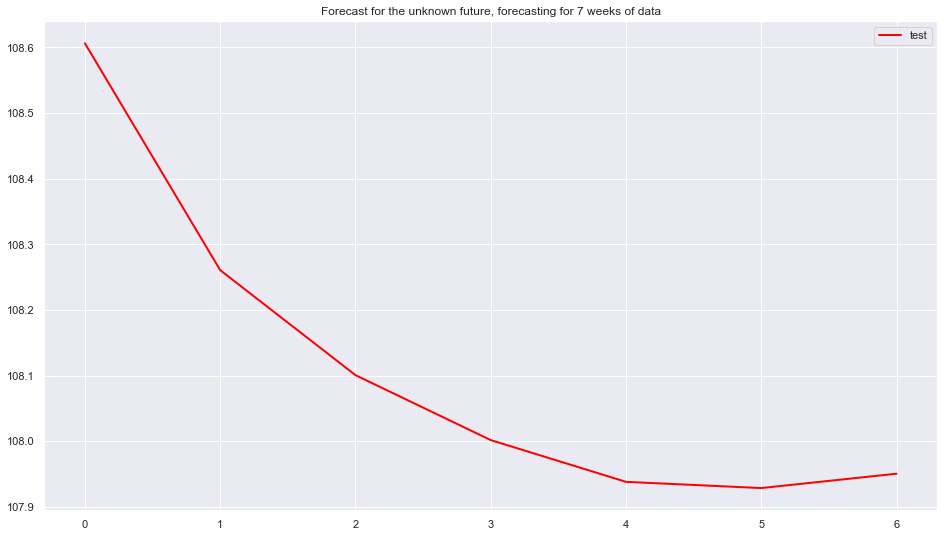

In [82]:
plt.figure(figsize=(16,9))
plt.plot(forcasted_output_lstm,'red', linewidth=2)
plt.legend((f'test','Forcast of {} days'.format(future)))
plt.title(f'Forecast for the unknown future, forecasting for {future} weeks of data')
plt.show()